# **Modelo de clasificación de videojuegos**

# **Entendimiento del negocio**
---

## **1. Contexto del negocio**
---
En este proyecto se usará un conjunto de datos con **`videojuegos`** que han vendido más de cien mil copias a nivel mundial. Se buscará hacer un análisis con base en atributos como el año de publicación, número de ventas, plataformas, entre otros.

## **2. Objetivos del proyecto**
---
- Interpretar los datos de ventas de múltiples tipos de videojuegos.
- Clasificar los juegos según su género.
- Evaluar el desempeño de distintos modelos de clasificación.

## **3. Planeación del proyecto**
---
1. Explorar el conjunto de datos por medio de descripciones generales.
2. Seleccionar las características pertinentes para llevar a cabo el análisis.
3. Preparar los datos de interés para mejorar la calidad del análisis y facilitar el procesamiento.
4. Contruir y entrenar modelos para clasificar los datos.
5. Evaluar el desempeño de los modelos con distintos hiperparámetros.
5. Interpretar los resultados y formular conclusiones con base en los objetivos planteados.

# **Entendimiento de los datos**
---

## **1. Adquisición de datos**
---

In [129]:
!pip install -U scikit-learn 

In [130]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# Configuraciones de Matplotlib
%matplotlib inline   
plt.rcParams['figure.dpi'] = 110

# Configuraciones de Seaborn
sns.set_theme('notebook')

Este material se realizó con las siguientes versiones:
- **`Python`**: 3.7.13
- **`Numpy`**: 1.21.6
- **`Pandas`**: 1.3.5
- **`Matplotlib`**: 3.2.2
- **`Seaborn`**: 0.11.2
- **`Scikit-learn`**: 1.0.2

In [131]:
!python --version
print('Numpy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', mpl.__version__)
print('Seaborn', sns.__version__)
print('Scikit-learn', sklearn.__version__)

Python 3.7.13
Numpy 1.21.6
Pandas 1.3.5
Matplotlib 3.2.2
Seaborn 0.11.2
Scikit-learn 1.0.2


Para este proyecto se utilizará el conjunto de datos [Video Game Sales](https://www.kaggle.com/datasets/gregorut/videogamesales) disponible en *Kaggle*.

In [132]:
games = pd.read_csv("data.csv")

## **2. Funciones de utilidad**
---

In [133]:
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  color=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")

In [134]:
def cumulative_explained_variance_plot(expl_variance):

  cum_var_exp = np.cumsum(expl_variance)

  plt.figure(dpi = 105, figsize = (10, 6))
  plt.title('Curva acumulativa de la varianza explicada VS número de componentes principales')
  plt.xlabel('Número de componentes principales')
  plt.ylabel('Varianza explicada acumulativa')  

  nc = np.arange(1, expl_variance.shape[0] + 1)

  plt.plot(nc, cum_var_exp, '--r')
  plt.plot(nc, cum_var_exp, 'c*', ms = 5)   
  plt.show()

## **3. Análisis exploratorio de datos**
---

### **2.1. Descripciones y selección de características**
---

Se seleccionan algunos datos de la tabla para adquirir un **`entendimiento general`** de la composición de las filas.

In [135]:
games.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


Con esta vista premilinar se identifica una columna que no aporta **`información relevante`** para el análisis que se busca realizar. Por esto, se elimina a continuación:

In [136]:
games = games.drop(columns=["Rank"])

Con esto, se revisa la **`información general`** del conjunto de datos y se puede detallar que la columna de año podría tener un formato más óptimo para el análisis.

In [137]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16598 non-null  object 
 1   Platform      16598 non-null  object 
 2   Year          16327 non-null  float64
 3   Genre         16598 non-null  object 
 4   Publisher     16540 non-null  object 
 5   NA_Sales      16598 non-null  float64
 6   EU_Sales      16598 non-null  float64
 7   JP_Sales      16598 non-null  float64
 8   Other_Sales   16598 non-null  float64
 9   Global_Sales  16598 non-null  float64
dtypes: float64(6), object(4)
memory usage: 1.3+ MB


# **Preparación de los datos**
---

## **1. Limpieza de datos**
---

Por medio del método **`info`** se identificó que los parámetros **`Year`** y **`Publisher`** son los únicos que poseen valores nulos o faltantes.

Entre estas columnas se tienen 329 **`entradas incompletas`** como máximo (menos del 2% de los datos totales). Así pues, es posible eliminar estas filas sin afectar negativamente el conjunto de datos.





In [138]:
games = games.dropna()

## **2. Transformación de datos**
---

Se realizan las modificaciones necesarias sobre la columna del año de publicación para que ésta tenga un formato numérico **`entero`**.

In [139]:
games.loc[:, "Year"] = games["Year"].astype(int)

## **3. Nuevos datos preparados**
---

Se selecciona una **`muestra aleatoria`** de la tabla para verificar el efecto de los cambios realizados.

In [140]:
games.sample(3)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
10774,InuYasha: Secret of the Divine Jewel,DS,2007,Role-Playing,Namco Bandai Games,0.09,0.0,0.00,0.01,0.10
6183,Monopoly,DS,2010,Misc,Electronic Arts,0.16,0.1,0.00,0.03,0.28
11087,Clockwork Knight,SAT,1994,Platform,Sega,0.00,0.0,0.09,0.00,0.09


De nuevo, se revisa la **`información general`** del conjunto de datos. Ahora todas las columnas están representadas por medio de formatos que se ajustarán mejor a las necesidades del proceso de análisis. Tampoco hay valores faltantes en la tabla.

In [141]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16291 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16291 non-null  object 
 1   Platform      16291 non-null  object 
 2   Year          16291 non-null  int64  
 3   Genre         16291 non-null  object 
 4   Publisher     16291 non-null  object 
 5   NA_Sales      16291 non-null  float64
 6   EU_Sales      16291 non-null  float64
 7   JP_Sales      16291 non-null  float64
 8   Other_Sales   16291 non-null  float64
 9   Global_Sales  16291 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 1.4+ MB


Con una **`descripción estadística básica`** muy general sobre las columnas numéricas de la tabla se identifican los géneros a tener en cuenta en el presente estudio. También es posible distinguir el **`rango`** que toma el conjunto con respecto a los años de publicación.

In [142]:
games.groupby("Genre").describe()

Year                                                         \
               count         mean       std     min     25%     50%     75%   
Genre                                                                         
Action        3251.0  2007.906183  6.072900  1980.0  2005.0  2009.0  2012.0   
Adventure     1274.0  2008.127943  4.908283  1983.0  2006.0  2009.0  2011.0   
Fighting       836.0  2004.630383  6.158271  1980.0  2000.0  2005.0  2009.0   
Misc          1686.0  2007.300119  4.680799  1980.0  2005.0  2008.0  2010.0   
Platform       875.0  2003.811429  6.386474  1981.0  2001.0  2004.0  2008.0   
Puzzle         570.0  2005.228070  6.180124  1981.0  2003.0  2007.0  2009.0   
Racing        1225.0  2004.835102  5.281356  1981.0  2002.0  2005.0  2009.0   
Role-Playing  1470.0  2007.051020  5.871507  1986.0  2004.0  2008.0  2011.0   
Shooter       1282.0  2005.918877  6.354083  1980.0  2003.0  2007.0  2010.0   
Simulation     848.0  2006.554245  4.872822  1981.0  2004.0  2008.0  2009.0   
Sports        2304.0  2005.477865  5.633659  1980.0  2002.0  2006.0  2009.0   
Strategy       670.0  2005.591045  5.438877  1991.0  2002.0  2007.0  2009.0   

                     NA_Sales            ... Other_Sales        Global_Sales  \
                 max    count      mean  ...         75%    max        count   
Genre                                    ...                                   
Action        2017.0   3251.0  0.265078  ...        0.05  10.57       3251.0   
Adventure     2016.0   1274.0  0.080008  ...        0.01   0.83       1274.0   
Fighting      2016.0    836.0  0.264043  ...        0.04   1.41        836.0   
Misc          2016.0   1686.0  0.235421  ...        0.03   2.85       1686.0   
Platform      2016.0    875.0  0.509703  ...        0.05   2.90        875.0   
Puzzle        2015.0    570.0  0.214053  ...        0.01   1.18        570.0   
Racing        2016.0   1225.0  0.291371  ...        0.05   7.53       1225.0   
Role-Playing  2017.0   1470.0  0.222109  ...        0.03   1.74       1470.0   
Shooter       2016.0   1282.0  0.448643  ...        0.07   2.52       1282.0   
Simulation    2020.0    848.0  0.214363  ...        0.03   2.75        848.0   
Sports        2016.0   2304.0  0.290838  ...        0.04   8.46       2304.0   
Strategy      2016.0    670.0  0.101239  ...        0.01   0.59        670.0   

                                                                   
                  mean       std   min   25%    50%    75%    max  
Genre                                                              
Action        0.529942  1.165238  0.01  0.07  0.190  0.500  21.40  
Adventure     0.184137  0.510902  0.01  0.02  0.060  0.160  11.18  
Fighting      0.531160  0.957915  0.01  0.08  0.210  0.550  13.04  
Misc          0.468488  1.332150  0.01  0.06  0.160  0.410  29.02  
Platform      0.947577  2.599940  0.01  0.09  0.280  0.815  40.24  
Puzzle        0.424930  1.577565  0.01  0.04  0.105  0.300  30.26  
Racing        0.593273  1.677373  0.01  0.07  0.190  0.530  35.82  
Role-Playing  0.628456  1.717452  0.01  0.07  0.190  0.530  31.37  
Shooter       0.800468  1.833578  0.01  0.08  0.230  0.740  28.31  
Simulation    0.459882  1.207428  0.01  0.05  0.160  0.430  24.76  
Sports        0.568247  2.104926  0.01  0.09  0.220  0.560  82.74  
Strategy      0.258612  0.524575  0.01  0.04  0.090  0.270   5.45  

[12 rows x 48 columns]

Al utilizar el método **`value_counts`** sobre la columna **`Genre`**, se puede concluir que los juegos más populares (según la cantidad de publicaciones) son aquellos que pertenecen a los géneros de acción y deportes con 3251 y 2304 ejemplos, respectivamente.

In [143]:
games["Genre"].value_counts()

Action          3251
Sports          2304
Misc            1686
Role-Playing    1470
Shooter         1282
Adventure       1274
Racing          1225
Platform         875
Simulation       848
Fighting         836
Strategy         670
Puzzle           570
Name: Genre, dtype: int64

Con el mismo método usado en la celda anterior, se muestra la **`frecuencia`** de juegos publicados por **`año`**.

In [144]:
games["Year"].value_counts().sort_index()

1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     349
2001     482
2002     829
2003     775
2004     744
2005     936
2006    1008
2007    1201
2008    1428
2009    1431
2010    1257
2011    1136
2012     655
2013     546
2014     580
2015     614
2016     342
2017       3
2020       1
Name: Year, dtype: int64

Para apreciar estos datos más claramente, se utiliza un histograma con el número de **`ocurrencias`** por año.

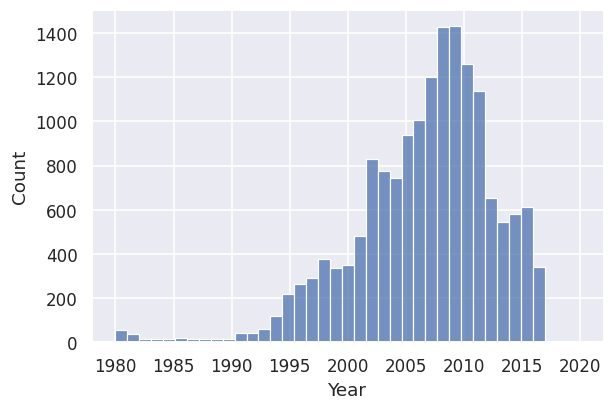

In [145]:
sns.histplot(games["Year"], bins=39);

# **Modelamiento**
---

## **1. Partición de registros**
---

Se genera la **`división`** entre la matriz de ejemplos y el vector de etiquetas objetivo.

In [146]:
X = games.drop(columns=["Genre"])
y = games["Genre"].values

Anteriormente se vio que el conjunto de datos posee algunas características representadas por medio de **`variables categóricas`**, por lo que es necesario **`codificarlas`** para que el modelo de aprendizaje reciba valores numéricos.

In [147]:
numeric = ["Year", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales"]
X_numeric = X[numeric].values # Selección de variables numéricas

In [148]:
X_categoric = X[["Platform", "Publisher"]].values # Selección de variables categóricas
enc = OneHotEncoder(sparse=False)
X_categoric_onehot = enc.fit_transform(X_categoric)

In [149]:
X = np.concatenate((X_numeric, X_categoric_onehot), axis=1)

También se separan los datos de **`entrenamiento`** de los ejemplos con los que, posteriormente, se estimará el desempeño del modelo. Para esto se usará el **20%** de los registros en la evaluación de **`prueba`**.

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## **2. Validación cruzada**
---

Para la **`clasificación`** de los videojuegos se utilizará el método de **`bosques aleatorios`**. Además, el modelo se evaluará con distintos valores en hiperparámetros como la cantidad de árboles de decisión y la proporción de carácteristicas a considerar.

In [151]:
parameters = {"n_estimators": [50, 75], "max_features": [0.5, 0.7]}

In [152]:
grid_clf = GridSearchCV(RandomForestClassifier(), parameters, verbose=3, return_train_score=True)
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END max_features=0.5, n_estimators=50;, score=(train=0.980, test=0.340) total time=  13.7s
[CV 2/5] END max_features=0.5, n_estimators=50;, score=(train=0.979, test=0.341) total time=  17.1s
[CV 3/5] END max_features=0.5, n_estimators=50;, score=(train=0.979, test=0.321) total time=  10.7s
[CV 4/5] END max_features=0.5, n_estimators=50;, score=(train=0.980, test=0.328) total time=   8.7s
[CV 5/5] END max_features=0.5, n_estimators=50;, score=(train=0.978, test=0.339) total time=   8.7s
[CV 1/5] END max_features=0.5, n_estimators=75;, score=(train=0.980, test=0.353) total time=  13.2s
[CV 2/5] END max_features=0.5, n_estimators=75;, score=(train=0.979, test=0.347) total time=  12.7s
[CV 3/5] END max_features=0.5, n_estimators=75;, score=(train=0.980, test=0.335) total time=  12.7s
[CV 4/5] END max_features=0.5, n_estimators=75;, score=(train=0.980, test=0.330) total time=  12.4s
[CV 5/5] END max_features=0.5, n_estimat

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': [0.5, 0.7], 'n_estimators': [50, 75]},
             return_train_score=True, verbose=3)

## **3. Reducción de dimensionalidad y visualización**
---

Se presenta una **`varianza explicada`** mayor al 90% con solo dos componentes de los registros.

Primeras 2 componentes: 0.948092508472139


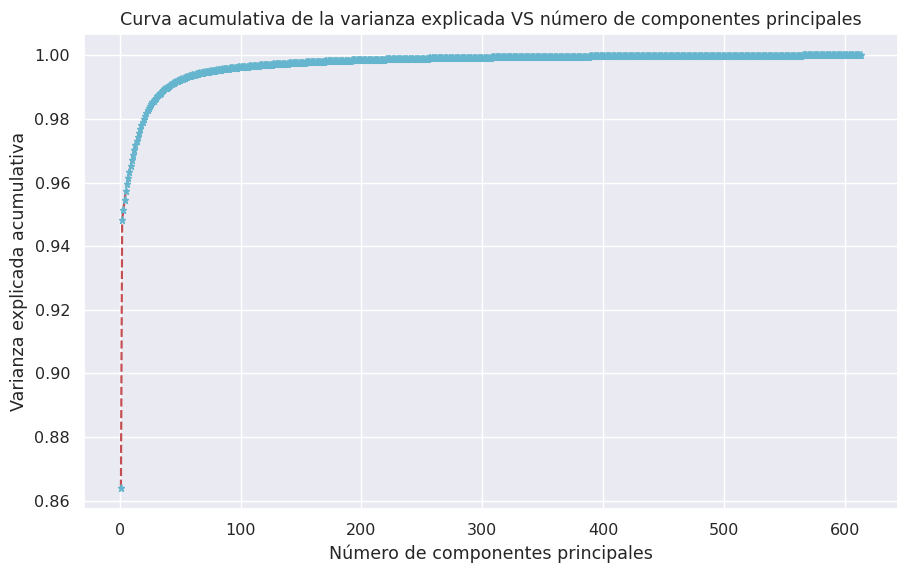

In [153]:
pca = PCA()

pca.fit_transform(X)
varianza_expl = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(varianza_expl)
print(f'Primeras 2 componentes: {cum_var_exp[1]}')
cumulative_explained_variance_plot(varianza_expl)

Al visualizar los datos con sus dos **`componentes principales`** no se logran identificar grupos bien definidos

In [154]:
sc = StandardScaler()
sc.fit(X)
X_scaled = sc.transform(X)

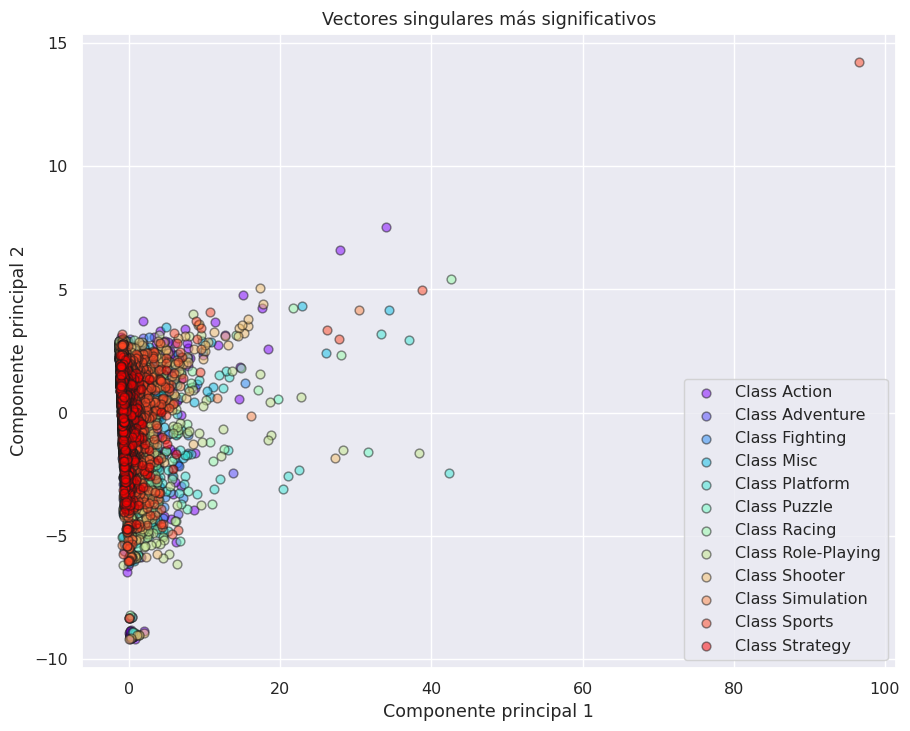

In [155]:
pca = PCA(n_components=2)
Xp = pca.fit_transform(X_scaled)

plt.figure(figsize = (10, 8), dpi = 105)
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.title("Vectores singulares más significativos")

plot_data(Xp, y)

# **Evaluación de desempeño**
---

## **1. Evaluación**
---

Se evalúa el desempeño del **`mejor clasificador`** en validación y se muestran sus parámetros.

In [156]:
print(f"Mejor score: {grid_clf.best_score_}")
print("Mejor configuración de parámetros:")

best_parameters = grid_clf.best_params_
for param in sorted(parameters.keys()):
    print(f"\t{param}: {best_parameters[param]}")

Mejor score: 0.3397774043023079
Mejor configuración de parámetros:
	max_features: 0.5
	n_estimators: 75


Por último, se utilizan los registros que no hicieron parte del entrenamiento para evaluar el desempeño del modelo al clasificar **`datos desconocidos`**.

In [157]:
grid_clf.score(X_test, y_test)

0.3451979134703897

## **2. Análisis de resultados**
---

Finalmente se encontró que los datos utilizados se encuentran muy dispersos sobre las distintas categorías objetivo, resultando en un modelo entrenado que no logró obtener **`rendimientos`** de validación y prueba satisfactorios.

El conjunto de datos no tuvo características lo suficientemente **`importantes`** como para aportar de forma significativa al desempeño de los **`árboles de decisión`** utilizados.

# **Referencias**
---
* [Kaggle - Video Game Sales](https://www.kaggle.com/datasets/gregorut/videogamesales)

# **Créditos**
---
* Samuel David Moreno Vahos